# Product Classifier - Complete
## Author: Luis Eduardo Ferro Diez, <a href="mailto:luisedof10@gmail.com">luisedof10@gmail.com</a>
This notebook contains the process of training the product classifier from scratch, i.e., from the raw document corpus. This is to validate the process of embeddings and classifier in general. For exploration and hyperparameter tuning for the neural network see the 'product-reviews-doc2vec' notebook.

In [1]:
dataset_path ="<path-to-documents>"

In [2]:
import modin.pandas as pd

documents = pd.read_parquet(dataset_path, engine='pyarrow')
documents.head()

,categories,document
0,Health & Personal Care,Great for sensitive skin\nThis lotion is gentl...
1,Books,Poorly Written\nI was very interested in the s...
2,Toys & Games,worst product ever!\nThese bubbles are neithe...
3,Books,"If I could unread this book, I would\nThis boo..."
4,Books,Another Manny Williams book!\nMy mom got me st...


In [3]:
documents.shape

(155715, 2)

In [4]:
categories = documents['categories'].str.split(';').explode().value_counts()
categories

To request implementation, send an email to feature_requests@modin.org.


Books                                    45552
Technology, Electronics & Accessories    26801
Home & Kitchen                           25259
Clothing, Shoes & Jewelry                16481
Health & Personal Care                   12414
Toys & Games                             11856
Sports & Outdoors                        10694
Music                                     8185
Movies & TV                               8147
Office & School Supplies                  2955
dtype: int64

### Baseline

In [5]:
baseline = categories['Books'] / categories.sum()
print(f"Baseline: {baseline:.4f}")

Baseline: 0.2706


In [35]:
%%time
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize, RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

#documents['tagged_documents'] = documents.apply(lambda row: TaggedDocument(words=word_tokenize(row['document']), tags=row['categories'].split(';')), axis=1)
#documents['tagged_documents'] = documents.apply(lambda row: TaggedDocument(words=[word.lower() for word in word_tokenize(row['document'])], tags=row['categories'].split(';')), axis=1)
#documents['tagged_documents'] = documents.apply(lambda row: TaggedDocument(words=tokenizer.tokenize(row['document']), tags=row['categories'].split(';')), axis=1)
documents['tagged_documents'] = documents.apply(lambda row: TaggedDocument(words=[word.lower() for word in tokenizer.tokenize(row['document'])], tags=row['categories'].split(';')), axis=1)
documents.head()

CPU times: user 8.29 s, sys: 770 ms, total: 9.06 s
Wall time: 23 s


,categories,document,tagged_documents,embedding
0,Health & Personal Care,Great for sensitive skin\nThis lotion is gentl...,"([great, for, sensitive, skin, this, lotion, i...","[-0.25634664, -0.11685726, 0.1432516, -0.05929..."
1,Books,Poorly Written\nI was very interested in the s...,"([poorly, written, i, was, very, interested, i...","[-0.17627177, -0.108491816, 0.030481316, -0.17..."
2,Toys & Games,worst product ever!\nThese bubbles are neithe...,"([worst, product, ever, these, bubbles, are, n...","[0.17021847, 0.15107383, 0.24789697, -0.246634..."
3,Books,"If I could unread this book, I would\nThis boo...","([if, i, could, unread, this, book, i, would, ...","[-0.24603297, -0.038587045, 0.15024066, -0.241..."
4,Books,Another Manny Williams book!\nMy mom got me st...,"([another, manny, williams, book, my, mom, got...","[-0.0976955, -0.0157045, -0.11014321, -0.36113..."


In [36]:
total_words = documents['tagged_documents'].apply(lambda x: len(x.words)).sum()
print(f"Total words: {total_words}")

Total words: 13809254


In [49]:
type(documents['tagged_documents'][0])

gensim.models.doc2vec.TaggedDocument

In [37]:
%%time
from gensim.models.doc2vec import Doc2Vec

d2v_model = Doc2Vec(vector_size=300,
                   alpha=0.025,
                   min_alpha=0.00025,
                   min_count=1,
                   dm=0,
                   workers=10)

d2v_model.build_vocab(documents['tagged_documents'])

CPU times: user 35 s, sys: 1.13 s, total: 36.2 s
Wall time: 39 s


In [38]:
%%time
for epoch in range(5):
    d2v_model.train(documents['tagged_documents'],
                    total_examples=d2v_model.corpus_count,
                    epochs=d2v_model.epochs,
                    total_words=total_words)
    d2v_model.alpha -= 0.0002
    d2v_model.min_alpha = d2v_model.alpha

CPU times: user 17min 42s, sys: 49.2 s, total: 18min 31s
Wall time: 8min 9s


In [39]:
%%time
documents['embedding'] = documents['tagged_documents'].apply(lambda x: d2v_model.infer_vector(x.words))
documents.head()

CPU times: user 523 ms, sys: 226 ms, total: 749 ms
Wall time: 521 ms


,categories,document,tagged_documents,embedding
0,Health & Personal Care,Great for sensitive skin\nThis lotion is gentl...,"([great, for, sensitive, skin, this, lotion, i...","[-0.305324, -0.12095416, 0.024939802, -0.15858..."
1,Books,Poorly Written\nI was very interested in the s...,"([poorly, written, i, was, very, interested, i...","[-0.13264447, -0.124034345, 0.017727409, 0.015..."
2,Toys & Games,worst product ever!\nThese bubbles are neithe...,"([worst, product, ever, these, bubbles, are, n...","[-0.19003437, -0.016289726, -0.182856, -0.1171..."
3,Books,"If I could unread this book, I would\nThis boo...","([if, i, could, unread, this, book, i, would, ...","[-0.19307962, -0.21498355, -0.13654096, -0.186..."
4,Books,Another Manny Williams book!\nMy mom got me st...,"([another, manny, williams, book, my, mom, got...","[-0.34602425, 0.023076577, 0.16358316, -0.2296..."


In [40]:
from sklearn.preprocessing import MultiLabelBinarizer

categories = documents.categories.apply(lambda cat: cat.split(";")).values.tolist()
categories_encoder = MultiLabelBinarizer()
categories_encoder.fit(categories)

MultiLabelBinarizer(classes=None, sparse_output=False)

In [41]:
%%time
y = categories_encoder.transform(categories)
# pure pandas
#X = documents.apply(lambda row: row['embedding'], axis=1, result_type='expand').values
# modin requires a _to_pandas() call to enable the expand feature
X = documents._to_pandas().apply(lambda row: row['embedding'], axis=1, result_type='expand').values

CPU times: user 17.6 s, sys: 311 ms, total: 17.9 s
Wall time: 23 s


In [42]:
X.shape

(155715, 300)

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [15]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto, InteractiveSession
from tensorflow.python.client import device_lib
                                                                     
config = ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
session = InteractiveSession(config=config)


def show_framework_devices():
    """Just prints the devices the frameworks are using
    at the moment. It will help us to tell if they are indeed
    using GPU's or not"""
    print("Tensorflow registered devices:", device_lib.list_local_devices())

In [16]:
show_framework_devices()

Tensorflow registered devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12707577291254263360
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10111586122986221174
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5022036787
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14571089323051039823
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 943261027866306499
physical_device_desc: "device: XLA_GPU device"
]


In [17]:
vec_size = 300
classes = y.shape[1]

In [44]:
from keras.layers import Input, Embedding, Bidirectional, Dense, Conv1D, Flatten, MaxPool1D, concatenate, BatchNormalization, Dropout, SpatialDropout1D
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam

#Define the inputs
comment_input = Input(shape=(vec_size,1), dtype='float32', name='comment_text')

# Put here ->  kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.2
# Add l2 first, evaluate if there is improvement 
conv = Conv1D(256, 5, activation='tanh', input_shape=(vec_size,), kernel_regularizer=regularizers.l2())(comment_input)
conv = MaxPool1D(2, strides=1, padding='valid')(conv)
conv = Conv1D(128, 4, activation='tanh')(conv)
conv = SpatialDropout1D(0.2)(conv)
conv = MaxPool1D(2, strides=1, padding='valid')(conv)
conv = Conv1D(64, 4, activation='tanh')(conv)
conv = MaxPool1D(2, strides=2, padding='valid')(conv)
conv = SpatialDropout1D(0.1)(conv)
conv_output = Flatten()(conv)


#Apply a dense layers
# minimize the dense layers - maybe add one of 64
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2())(conv_output)
x = Dense(128, activation='relu')(conv_output)
x = Dropout(0.5)(x)

#And finally make the predictions using the previous layer as input
main_output = Dense(classes, activation='softmax', name='prediction')(x)

ann_model = Model(inputs=comment_input, outputs=main_output)
optimizer = Adam(learning_rate=0.00001)
ann_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
ann_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
comment_text (InputLayer)    (None, 300, 1)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 296, 256)          1536      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 295, 256)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 292, 128)          131200    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 292, 128)          0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 291, 128)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 288, 64)           3283

In [45]:
%%time
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-7, restore_best_weights=True)
sample_size = 10000
X_train_rs = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
history = ann_model.fit(X_train_rs, 
                        y_train, 
                        epochs = 100, 
                        batch_size = 2000, 
                        validation_split= 0.2, 
                        callbacks=[early_stopping])

Train on 87200 samples, validate on 21800 samples
Epoch 1/100
87200/87200 [==============================] - 11s 127us/step - loss: 2.4384 - accuracy: 0.2860 - val_loss: 2.3586 - val_accuracy: 0.2919
Epoch 2/100
87200/87200 [==============================] - 11s 125us/step - loss: 2.2906 - accuracy: 0.2945 - val_loss: 2.2137 - val_accuracy: 0.2919
Epoch 3/100
87200/87200 [==============================] - 11s 126us/step - loss: 2.1930 - accuracy: 0.3154 - val_loss: 2.1182 - val_accuracy: 0.2988
Epoch 4/100
87200/87200 [==============================] - 11s 127us/step - loss: 2.0957 - accuracy: 0.3710 - val_loss: 1.9892 - val_accuracy: 0.4240
Epoch 5/100
87200/87200 [==============================] - 11s 127us/step - loss: 1.9579 - accuracy: 0.4421 - val_loss: 1.8210 - val_accuracy: 0.5228
Epoch 6/100
87200/87200 [==============================] - 11s 127us/step - loss: 1.7910 - accuracy: 0.5112 - val_loss: 1.6242 - val_accuracy: 0.5910
Epoch 7/100
87200/87200 [=========================

In [46]:
import matplotlib.pyplot as plt

def plot_history(cnn, acc= 'acc', val_acc = 'val_acc', loss = 'loss', val_loss = 'val_loss'):
    fig = plt.figure(figsize = (16, 8))
    plt.subplot(1, 2, 1)
    plt.title('Accuracy in training Vs validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.plot(cnn.history[acc], 'r')
    plt.plot(cnn.history[val_acc], 'b')
    plt.legend(['training', 'validation'])
    
    plt.subplot(1, 2, 2)
    plt.title('Loss in training Vs validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.plot(cnn.history[loss], 'r')
    plt.plot(cnn.history[val_loss], 'b')
    plt.legend(['training', 'validation'])
    
    plt.show()

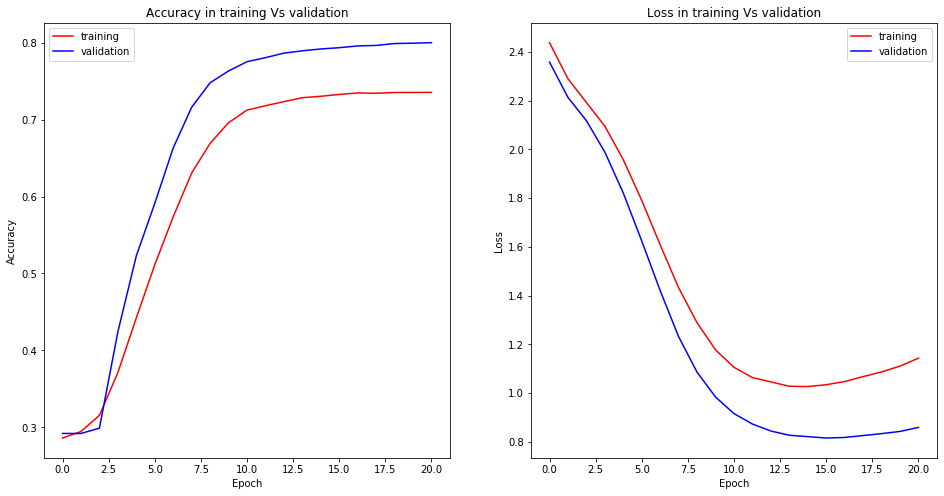

In [47]:
plot_history(history, 
             acc='accuracy', 
             val_acc='val_accuracy', 
             loss='loss', 
             val_loss='val_loss')